In [73]:
# required libraries
import pandas as pd
import geopandas as gpd
import os
import pylab as plt
from importlib import reload
import wbdata
import matplotlib.ticker as ticker

# pyEmdat

reload(emdat_df)
reload(utils)
import emdat_df
from emdat_df import emdat
import utils
from utils import rebase_CPI

# config
%pylab inline
data = os.getenv('data')

Populating the interactive namespace from numpy and matplotlib


/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Example queries with pyEmdat
This notebook shows a set of example queries using an EMDAT dataset of disaster events since 1960 for the world:
* number of events for selected countries/dates/hazards
* disaster stats for selected countries/dates/hazards (grouped by hazard or country)
* annual average loss for selected countries/dates/hazard (grouped by hazard)
* breakdown of disaster impacts for a single period (grouped by hazard or country)
* disaster stats per capita (using WDI population data)

The key steps are below. pyEmdat makes these queries easy: just load the data as an *emdat* object then use the built-in methods which filter, group and aggregate the individual disaster records to produce the required outputs. *Possible additions are in the table below - what else do people need? What are frequent uses of this dataset which can be made easier?*

| possible additions                                                    |
|-----------------------------------------------------------------------|
| create choropleth maps                                                |
| total damage for period, 2010 real gni                                |
| average annual loss (selected countries/period/hazard), 2010 real gni |

## 1. Load downloaded Excel file as a PyEmdat object

In [74]:
ED = emdat((data + '/emdat_1960.xlsx'))

/home/nicholasjones/Code/pyEmdat/emdat_df.py:40: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  self.data = pd.read_excel(filename, header = 6).rename(columns = cols_dict)


## 2. Number of events for selected countries, dates and hazards

In [35]:
ED.data.head(1)

,dis_no,year,Seq,disaster_group,disaster_subgroup,disaster_type,disaster_subtype,Disaster Subsubtype,event_name,Entry Criteria,...,End Day,deaths,injured,affected,homeless,total_affected,reconstruction_costs,insured_damages,total_damages,CPI
0,1960-0013-CHL,1960,13,Natural,Geophysical,Earthquake,Tsunami,NaN,NaN,Kill,...,22.0,6000.0,3000.0,2000000.0,NaN,2003000.0,NaN,NaN,550000.0,11.568216


In [10]:
df = ED.disaster_count_timeseries(1960, 2000, countries = 'all', disastertype = ['Storm','Flood', 'Earthquake','Volcanic activity','Landslide'])
df.head(2)

disaster_type,Earthquake,Flood,Landslide,Storm,Volcanic activity
year,,,,,
1961,3.0,8.0,2.0,14.0,0.0
1962,4.0,8.0,2.0,13.0,0.0


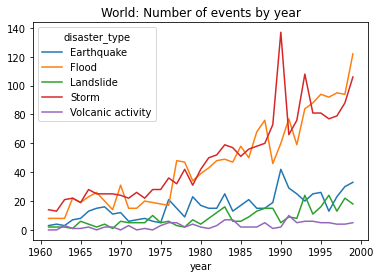

In [11]:
df.plot(title = 'World: Number of events by year');

## 3. Time series grouped by hazard (for selected countries & dates)

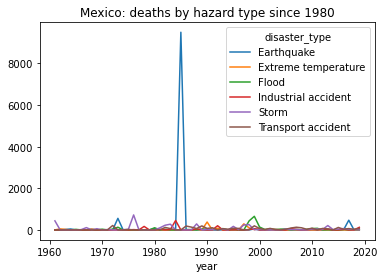

In [12]:
df = ED.disaster_stats_timeseries(1960, 2020, 'Mexico','all','deaths')
cols_over_1000 = [column for column in df.columns if df[column].sum() > 1000]
df[cols_over_1000].plot(title = 'Mexico: deaths by hazard type since 1980');

## 4. Time series grouped by country (for selected dates & hazard)

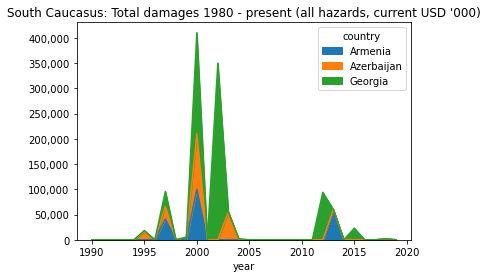

In [94]:
df = ED.country_stats_timeseries(1980, 2020, ['Georgia','Armenia','Azerbaijan'],'all','total_damages')
ax = df.plot.area(title = "South Caucasus: Total damages 1980 - present (all hazards, current USD '000)")
y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));

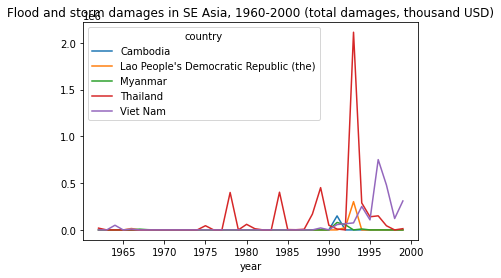

In [15]:
df = ED.country_stats_timeseries(1960, 2000, ["Lao People's Democratic Republic (the)",'Cambodia','Thailand','Viet Nam','Myanmar'],['Flood','Storm'],'total_damages')
df.plot(title = 'Flood and storm damages in SE Asia, 1960-2000 (total damages, thousand USD)');

## 5. Annual average loss grouped by hazard

In [101]:
df = ED.aal_by_disaster_type(1960, 2020, 'Indonesia', 'all',base_year=2010)
df = df[df>0]
df

disaster_type
Earthquake                282322
Wildfire                  242237
Flood                     149826
Volcanic activity          20529
Drought                     8745
Landslide                   3215
Industrial accident         1314
Mass movement (dry)           34
Storm                         16
Miscellaneous accident         9
dtype: int64

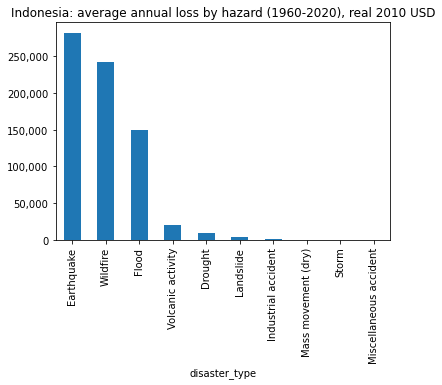

In [103]:
ax = df.plot(kind = 'bar')
plt.title('Indonesia: average annual loss by hazard (1960-2020), real 2010 USD')
y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [162]:
df_decades=pd.DataFrame({'1970s': ED.aal_by_disaster_type(1970, 1980, 'Indonesia', 'all',base_year=2010),
                        '1980s':ED.aal_by_disaster_type(1980, 1990, 'Indonesia', 'all',base_year=2010),
                        '1990s':ED.aal_by_disaster_type(1990, 2000, 'Indonesia', 'all',base_year=2010),
                        '2000s':ED.aal_by_disaster_type(2000, 2010, 'Indonesia', 'all',base_year=2010),
                        '2010s':ED.aal_by_disaster_type(2010, 2020, 'Indonesia', 'all',base_year=2010)})
df_decades = df_decades.fillna(0)
df_decades['mean'] = df_decades.mean(axis=1)
df_decades.sort_values(ascending=False, by='mean')
df_decades=df_decades[:4]
df_decades.drop(columns='mean',inplace=True)


In [163]:
def thousands(x, pos):
    return('{:,.0f}'.format(x*1e-3))

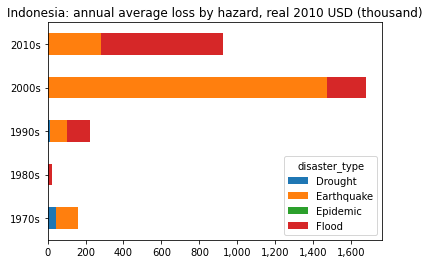

In [164]:
ax = df_decades.T.plot(kind='barh',stacked=True)
plt.title('Indonesia: annual average loss by hazard, real 2010 USD (thousand)')
x_labels = ax.get_xticks()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands));

## 6. Disaster statistics for a single period (eg. sum of damages from year x to y)

In [69]:
result = ED.disaster_stats_total_for_period(1990, 2000, countries = ['Bangladesh'], disastertype = ['Storm'], stats = ['total_affected'])
print("Total people affected by storm in Bangladesh 1990-2000: {:,.0f}".format(result))

Total people affected by storm in Bangladesh 1990-2000: 23,603,895


## 7. Single period grouped by disaster types

In [70]:
result = ED.disaster_stats_entire_period(1980, 2020, countries = ['Pakistan'], disastertype = [], stats = ['total_damages'])
result

,total_damages
disaster_type,
Flood,19911378.0
Earthquake,5348500.0
Storm,1710936.0
Drought,247000.0
Industrial accident,179080.0
Miscellaneous accident,22000.0
Extreme temperature,18000.0
Landslide,18000.0
Epidemic,0.0


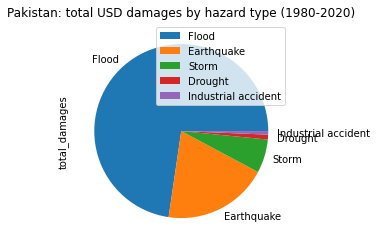

In [75]:
result = ED.disaster_stats_entire_period(1980, 2020, countries = 'Pakistan', disastertype = 'all', stats = ['total_damages'])
result.head().plot(kind = 'pie', y='total_damages', figsize =[4,4])
plt.title('Pakistan: total USD damages by hazard type (1980-2020)');